# Viscoporoelastic Model Inversion
Rahul Yerrabelli
2021

# Setup

In [ ]:
pip install --upgrade matplotlib # want version 3.4

     |████████████████████████████████| 11.2 MB 24.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
#@title ## Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display
import os
import time

import itertools
import inspect 
import math

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

import warnings
warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [3]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
        pass
        #sys.path.insert(0,new_path)
    %cd "/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src"
    #%cd "/content/gdrive"
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()


#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
#from inverting import euler_inversion
import inverting
import plotting
import viscoporoelastic_model
from viscoporoelastic_model import CohenModel


<IPython.core.display.Javascript object>

/root
Mounted at /content/gdrive
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Key Points from Prior Paper
Yuan, D., Somers, S.M., Grayson, W.L. et al. A Poroelastic Model of a Fibrous-Porous Tissue Engineering Scaffold. Sci Rep 8, 5043 (2018). https://doi.org/10.1038/s41598-018-23214-8

## Figure 1
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-23214-8/MediaObjects/41598_2018_23214_Fig1_HTML.jpg?as=webp">

## Table 1
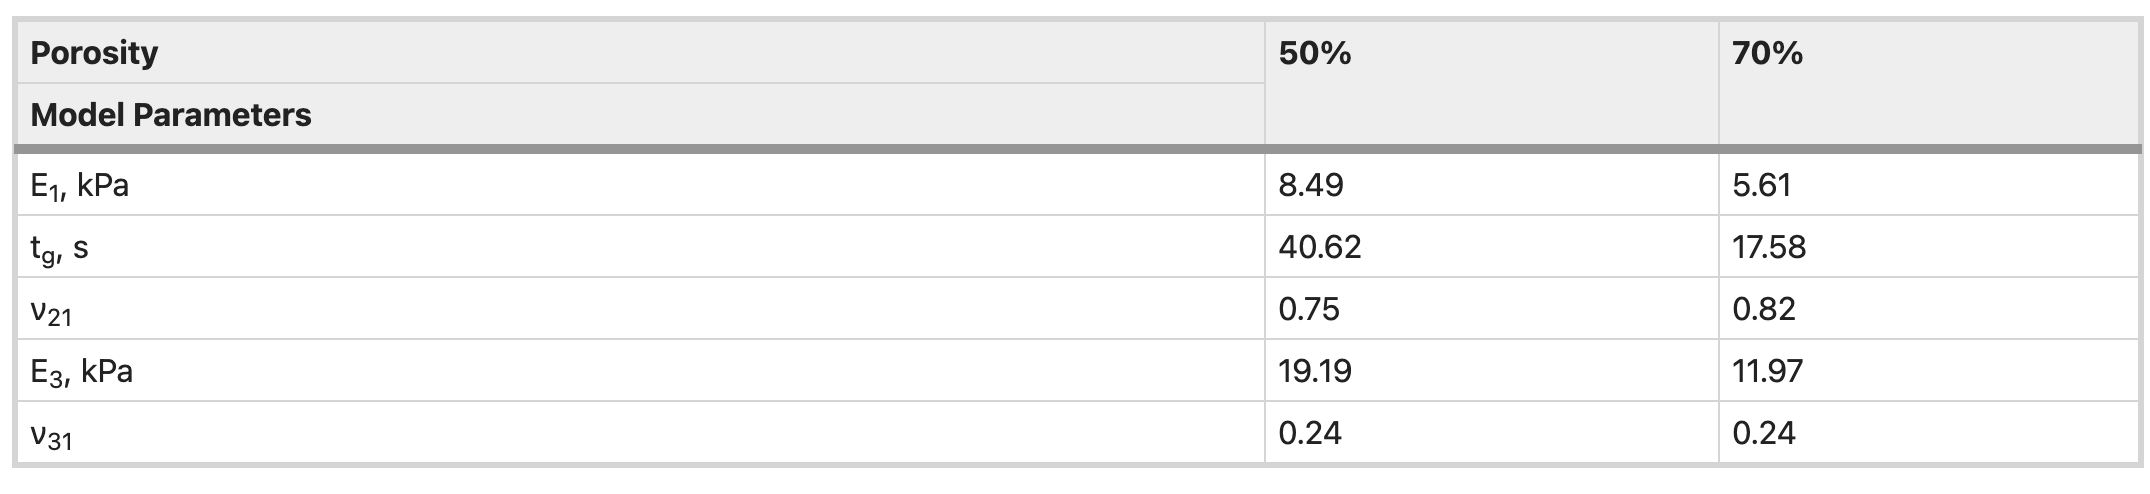

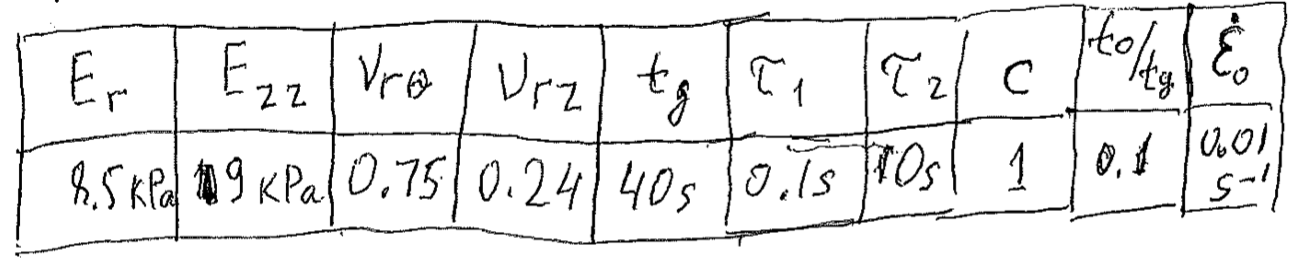

# Simple Laplace Model Inversion
$$ F(s)=\frac{1}{s-a} $$
$$ f(t)={\mathrm{e}}^{a t}$$

<IPython.core.display.Javascript object>

It took 0.0000 sec to evaluate the Laplace space func for 100 input s vals.
It took 0.0042 sec to numerically invert Laplace the func for 999 input times.


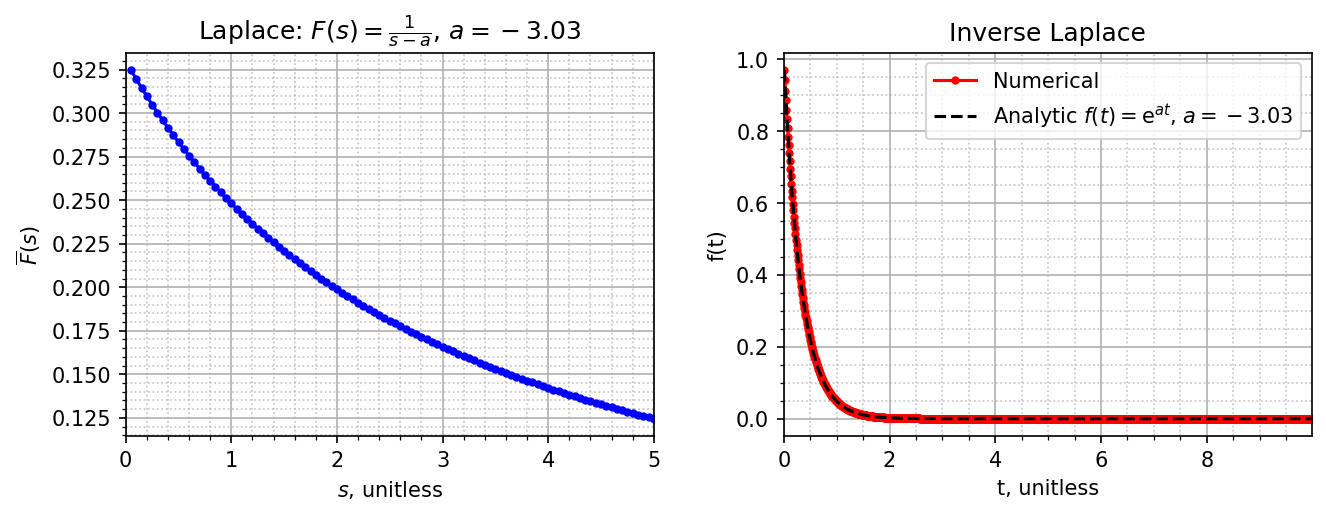

In [12]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10
times=np.arange(0.1,100,0.1)/100.0*10

input_times = times
plot_times  = times
input_times_anal = input_times
plot_times_anal = plot_times/1  #tg=1


# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\mathrm{e}}^{a t}=\exp{\left(a t\right)} $$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)
plot_props = {
    "t":        {"y":{"name":r"f(t)"}, "x":{"name":r"t, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}, 
                 "eqn":{"text":r"$F(s)=\frac{1}{s-a}$, $a="+str(a)+r"$"}},
    "t_anal":   {"eqn":{"text":r"$f(t)={\mathrm{e}}^{a t}$, $a="+str(a)+r"$"}},
}
input_s = np.arange(0.05, 5.05, 0.05)


_=plotting.plot_laplace_analysis(funcs=funcs, plot_props=plot_props, input_s=input_s, 
                                 input_times=input_times, plot_times=plot_times, time_const=1, 
                                 input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
                                 plot_mode="simple")


# Cohen Model Inversion

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0013 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.2884 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0_tg,0.246184,Constant
tg,40.620000,Constant
strain_rate,0.010000,Constant
E1,8.500000,Constant
E3,19.000000,Constant
v21,0.750000,Constant
v31,0.240000,Constant
Δ1,0.198463,Calculated
Δ2,0.556704,Calculated
Δ3,2.481929,Calculated


array([   5.3610301 ,   30.06125439,   74.47854152,  138.63230093,
        222.52453078,  326.15569064,  449.52593136,  592.63531408,
        755.48386735,  938.07160598, 1140.39853824, 1362.46466905,
       1604.2700015 , 1865.81453758, 2147.09827865, 2448.12122564,
       2768.88337922, 3109.38473987, 3469.62530795, 3849.60508374])

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0_tg,0.246184,Constant
tg,40.620000,Constant
strain_rate,0.010000,Constant
E1,3.500000,Constant
E3,19.000000,Constant
v21,0.750000,Constant
v31,0.240000,Constant
Δ1,0.228779,Calculated
Δ2,0.565365,Calculated
Δ3,2.186544,Calculated


array([   5.3016742 ,   30.0054949 ,   74.42321361,  138.57710671,
        222.46939485,  326.10058528,  449.47084399,  592.58023818,
        755.42879923,  938.01654336, 1140.34347965, 1362.40961352,
       1604.21494832, 1865.75948627, 2147.04322884, 2448.06617705,
       2768.82833164, 3109.32969313, 3469.57026193, 3849.55003832])

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,0.246184,40.62,0.01,3.5,19,0.75,0.24,0.228779,0.565365,2.186544,8.649305,6.649305,3.671667,20.762400,0.231232,21.068372,36.889982


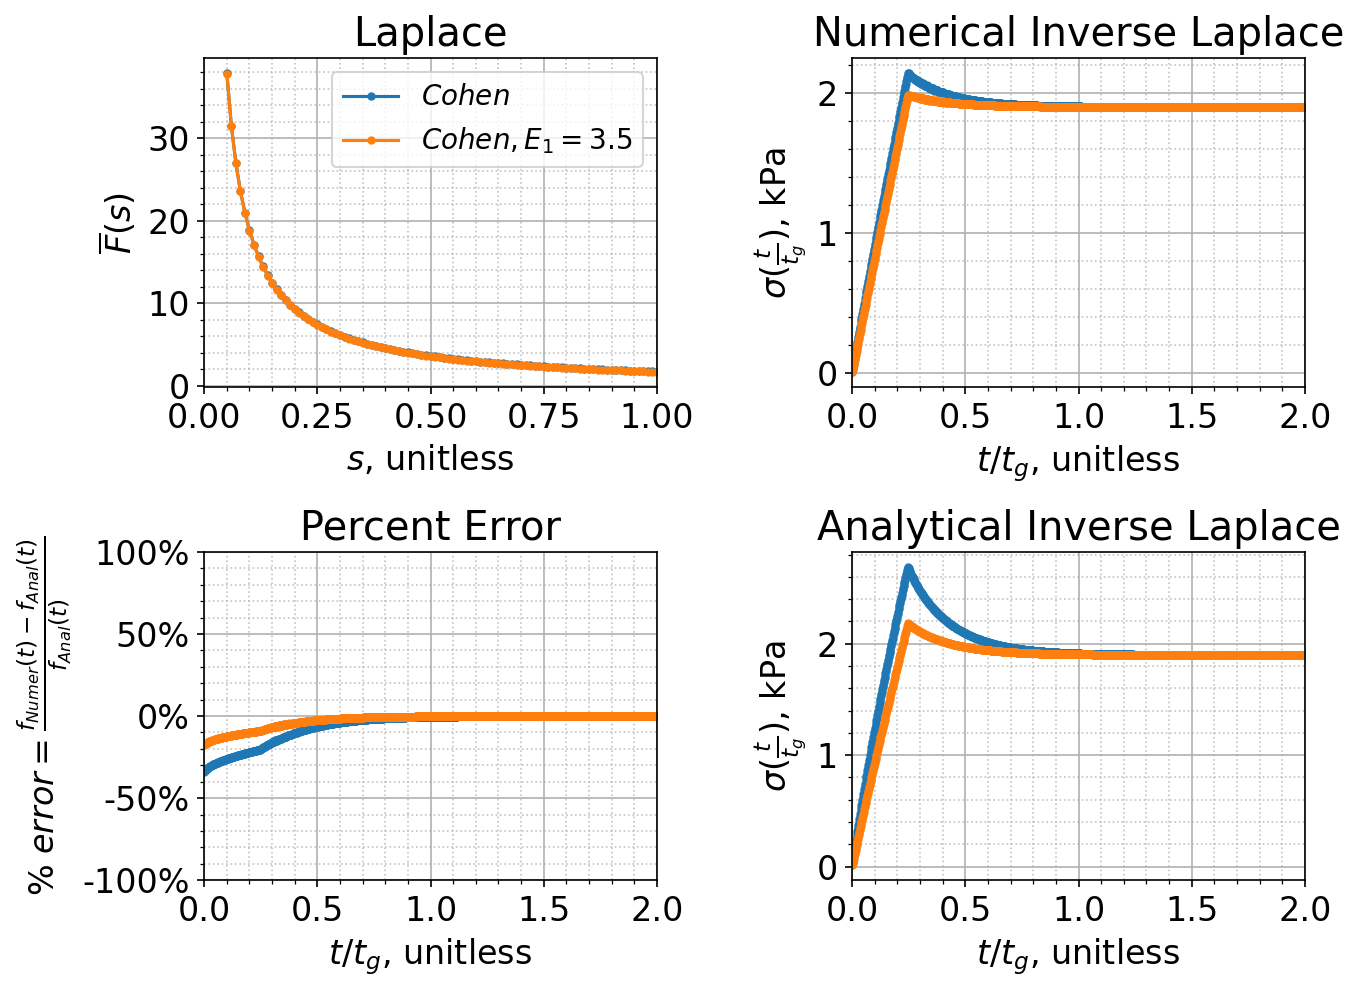

In [ ]:
#@markdown Cohen Inversion
from
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified


VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") ]

t0_tg = VPEs[0][0].t0_tg
tg = VPEs[0][0].tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    display(vpe.get_var_df())
    display(vpe.alpha2_vals)

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[-757.98-0.j    0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new inst

(-30.0, 50.0)

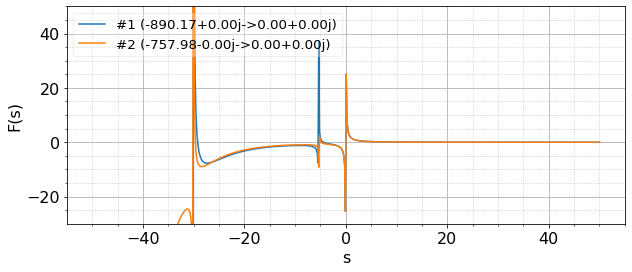

In [ ]:
importlib.reload(inverting)

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 

F_s_recalcs = [
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s, times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_analytical_all[ind], plot_s, times=input_times_anal ) for ind, _ in enumerate(VPEs) ],
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],

               #*[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s, times=np.linspace(0, 100, num=100001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s, F_s_recalc, label=f"#{ind+1} ({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.xlim([-0.5,None])
plt.ylim([-30, 50])

#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)


In [ ]:
# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x): return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x): return sp.special.iv(1, x) #besseli(1, x)
I1rts_s = I1(sqrt(s)) / sqrt(s)
I0rts = I0(sqrt(s))

eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s))/ (s*s)
numer = (C1*I0rts - C2*C0*I1rts_s)
denom = (I0rts - C0*I1rts_s) * s*s


In [ ]:
#VPEs = [(viscoporoelastic_model.CohenModel1998(), fr"$Cohen$") ]
for VPE, name in VPEs:
    print()
    print(name)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()
    vpe.setup_constants(bessel_len=100)
    alpha2_vals = vpe.alpha2_vals

    print(f"strain_rate*t0*(2*C1-C2*C0)/(2-C0)=\t{strain_rate*t0*(2*C1-C2*C0)/(2-C0)}")
    print(f"strain_rate*t0*2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"strain_rate*t0*E3=\t{strain_rate*t0*E3}")
    print(f"2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"(2*C1-C2*C0)/(2-C0)=\t{(2*C1-C2*C0)/(2-C0)}")
    print(f"E3=\t{E3}")


<IPython.core.display.Javascript object>


$Cohen$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19

$Cohen, E_1=3.5$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19


In [ ]:
"""
(2*C33*(C11+C12)-4*C13*C13)/(C11*(C11-C12)), 2*C1-C2*C0
(C11+C12)/C11, 2-C0

E3+2*v31*v31*E1/delta1, C33
E1/(1+v21), C11-C12
E1/delta1, C11+C12
strain_rate*t0*2*E3/E1*(1+v21)
"""

def getCohenModelModified(**kwargs):
    class CohenModelModified2(CohenModel):
        t0_tg = 10 / 40.62;
        tg = 40.62  # sec
        strain_rate = 0.01;  # per sec
        E1 = 8.5  # kPa
        E3 = kwargs.get("E3",19*1.5) or 19*1.5   # kPa
        v21 = 0.75  # like Vrtheta
        v31 = 0.24  # like Vrz
    return CohenModelModified2()


VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(), fr"$Cohen$2") ]
[VPE.laplace_value for VPE, name in VPEs]
print(CohenModel.E3)

<IPython.core.display.Javascript object>

19


<IPython.core.display.Javascript object>

[3.15377282e-08 4.46053371e-03 1.67565916e+00 1.67670166e+00
 1.67328351e+00 1.00000000e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1205: RuntimeWarning: overflow encountered in exp
  for alpha2_N in alpha2_vals
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel1998 - Line #1,1,1,0.01,5,1,0.3,0,0.7,0.769231,1.098901,5.494505,1.648352,0.0,1.0,0.7,2.377143,5.826122


0.0052000000000000015

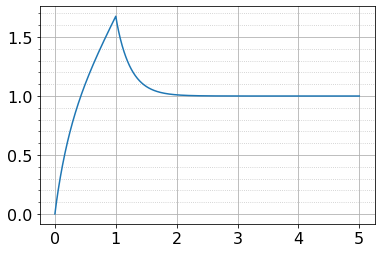

In [ ]:
"importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel1998(), 
         fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()
#VPEs[0][0].inverted_value(t=0)
VPEs[0][0].setup_constants(bessel_len=100)
alpha2_vals = VPEs[0][0].alpha2_vals

#sum(1/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))) => 0.9785392135865333 for len=10,000
"""
print(E3)
print(sum(np.exp(-alpha2_vals * t0_tg)/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))))
#alpha2_vals
print((1 - 2*v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
print((1 - v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
"""

input_times = np.linspace(0.00, 5, num=1001, endpoint=True) * tg
#output = VPEs[0][0].inverted_value(t=input_times)
t=input_times
output1 = E3*strain_rate*np.minimum(t, t0)
exp = np.exp
output2 = E1*strain_rate*tg*delta3*(1/8*(t<t0) - sum( (exp(-alpha2_N * t/tg) - exp(-alpha2_N * (t-t0)/tg )*(t>=t0) ) / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21)))
                for alpha2_N in alpha2_vals
    ))
output = output1 + output2 #+ 4*E3*strain_rate*t0*(t<t0)
output = VPEs[0][0].inverted_value(t)
print(VPEs[0][0].inverted_value(t=np.array([0,0.001,t0*0.999,t0,t0*1.001,10]))/(E3*strain_rate*t0))

plt.figure()
plt.plot(input_times/(t0),output/(E3*strain_rate*t0) )
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)



# Viscoporoelastic Models Inversions

<IPython.core.display.Javascript object>

It took 0.0259 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
It took 1.2219 sec to numerically invert Laplace the func for 1001 input times.


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.700,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.725,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.750,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.775,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.800,FittedParam
Err,8.490,FittedParam


,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err,t0
ViscoporoelasticModel1 - Line #1,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.700,8.49,4.062
ViscoporoelasticModel1 - Line #2,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.725,8.49,4.062
ViscoporoelasticModel1 - Line #3,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.750,8.49,4.062
ViscoporoelasticModel1 - Line #4,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.775,8.49,4.062
ViscoporoelasticModel1 - Line #5,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.800,8.49,4.062


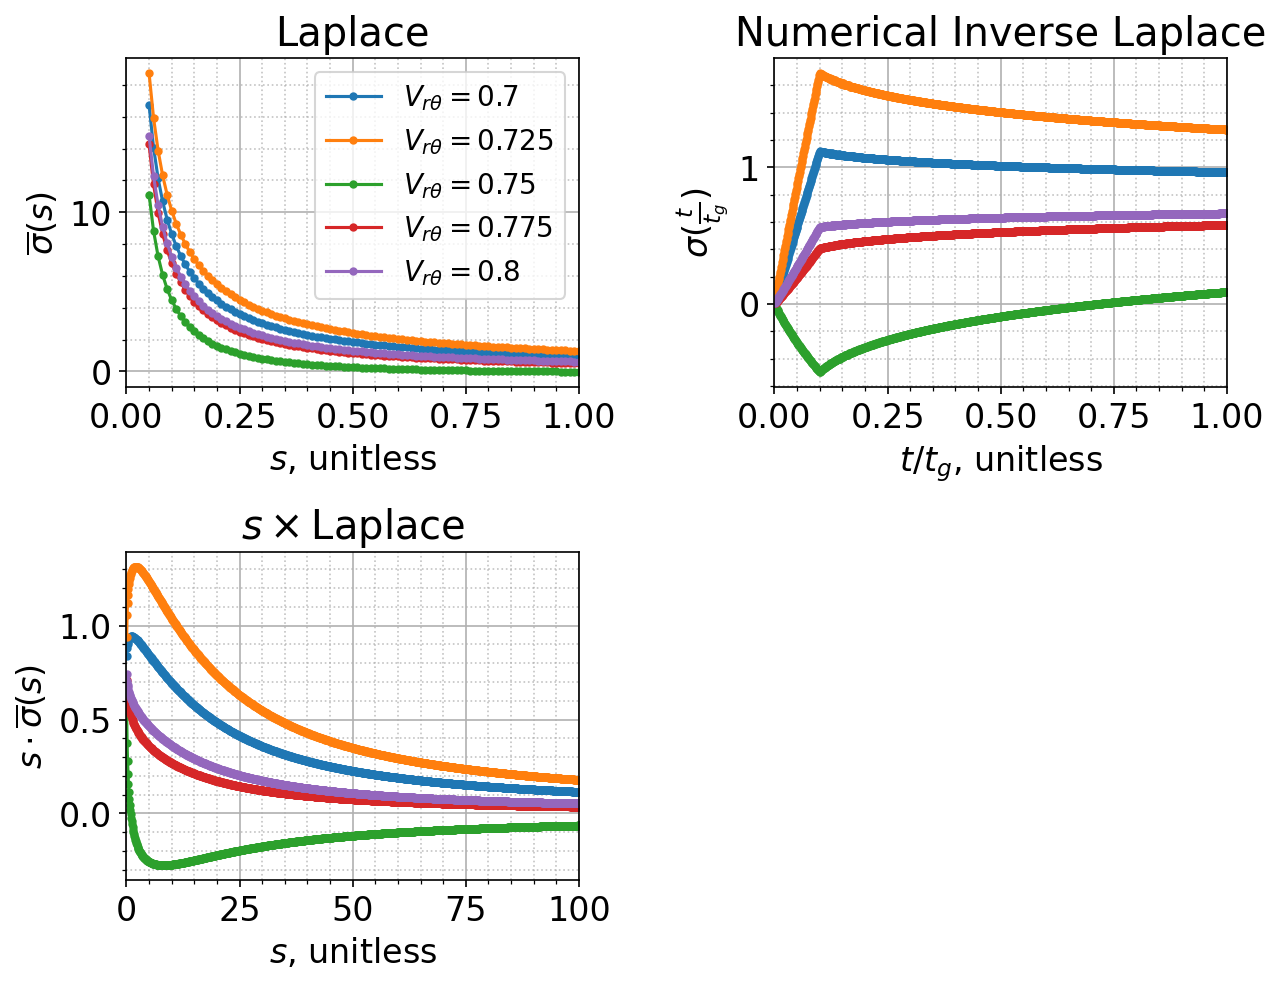

In [ ]:
#@title # ViscoporoelasticModel1


importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel1

#warnings.simplefilter('error') # throws all warnings as errors
#%pdb off

#@markdown Predefined constants
ViscoporoelasticModel1.t0_tg = 0.1 #@param {type:"number"} ; # 10 percent
ViscoporoelasticModel1.strain_rate = 0.01 #@param {type:"number"} ; # 1 percent per s (normally 1#/s)
## Below are directly determined by the mesh deformation part of the
## experiment (see our paper with Daniel).  -Dr. Spector
ViscoporoelasticModel1.Vrz = 0.24 #@param {type:"number"} ; # Not actually v, but greek nu (represents Poisson's ratio)
ViscoporoelasticModel1.Ezz =   19.19 #@param {type:"number"} ; # Note- don't mix up Ezz with epszz

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel1(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$V_{{r\theta}}={Vrtheta}$") 
                              for Vrtheta in [0.7, 0.725, 0.75, 0.775, 0.8]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    display(vpe.get_var_df())

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)


In [ ]:
#@title # ViscoporoelasticModel2
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel2

VPEs = [(ViscoporoelasticModel2(t0_tg=t0_tg), fr"$t_0/t_g={t0_tg}$") 
                              for t0_tg in [1, 10]]
tg = VPEs[0][0].tg
t0_tg = VPEs[0][0].t0_tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.01, 25, num=10001, endpoint=True)*tg
#plot_times = np.logspace(-3, 4, num=10001, endpoint=True)*tg
#input_times = plot_times
plot_times_log = np.logspace(-3, 3, num=10001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$T(\frac{t}{t_g})$", "s":r"$\overline{T}(s)$"}
x_names   = {"t":"$t/t_g$, unitless", "s":"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$T(\frac{t}{t_g})$"}, "x":{"name":"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{T}(s)$"},  "x":{"name":"$s$, unitless"}},
  }
plot_s = np.linspace(0.01, 0.4, num=1001, endpoint=True)
plot_s_s = np.linspace(1, 1000, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))

plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s, 
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)
ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() for vpe, label in VPEs])
display(df_params)

<IPython.core.display.Javascript object>

It took 0.0106 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some (168/2002) values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are 0-4,1001-1163. The values are [0.001      0.002999   0.004998   0.006997   0.008996   0.001
 0.00101391 0.00102802 0.00104232 0.00105682 0.00107152 0.00108643
 0.00110154 0.00111686 0.0011324  0.00114815 0.00116413 0.00118032
 0.00119674 0.00121339 0.00123027 0.00124738 0.00126474 0.00128233
 0.00130017 0.00131826 0.0013366  0.00135519 0.00137404 0.00139316
 0.00141254 0.00143219 0.00145211 0.00147231 0.00149279 0.00151356
 0.00153462 0.00155597 0.00157761 0.00159956 0.00162181 0.00164437
 0.00166725 0.00169044 0.00171396 0.0017378  0.00176198 0.00178649
 0.00181134 0.00183654 0.00186209 0.00188799 0.00191426 0.00194089
 0.00196789 0.00199526 0.00202302 0.00205116 0.0020797  0.00210863
 0.00213796 0.0021677  0.00219786 0.00222844 0.00225944 0.00229087


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err,t0
ViscoporoelasticModel3 - Line #1,0.246184,0.01,0.24,19,0.0,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #2,0.246184,0.01,0.24,19,0.5,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #3,0.246184,0.01,0.24,19,1.0,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #4,0.246184,0.01,0.24,19,2.0,0.1,10,40.62,0.75,8.49,10.0


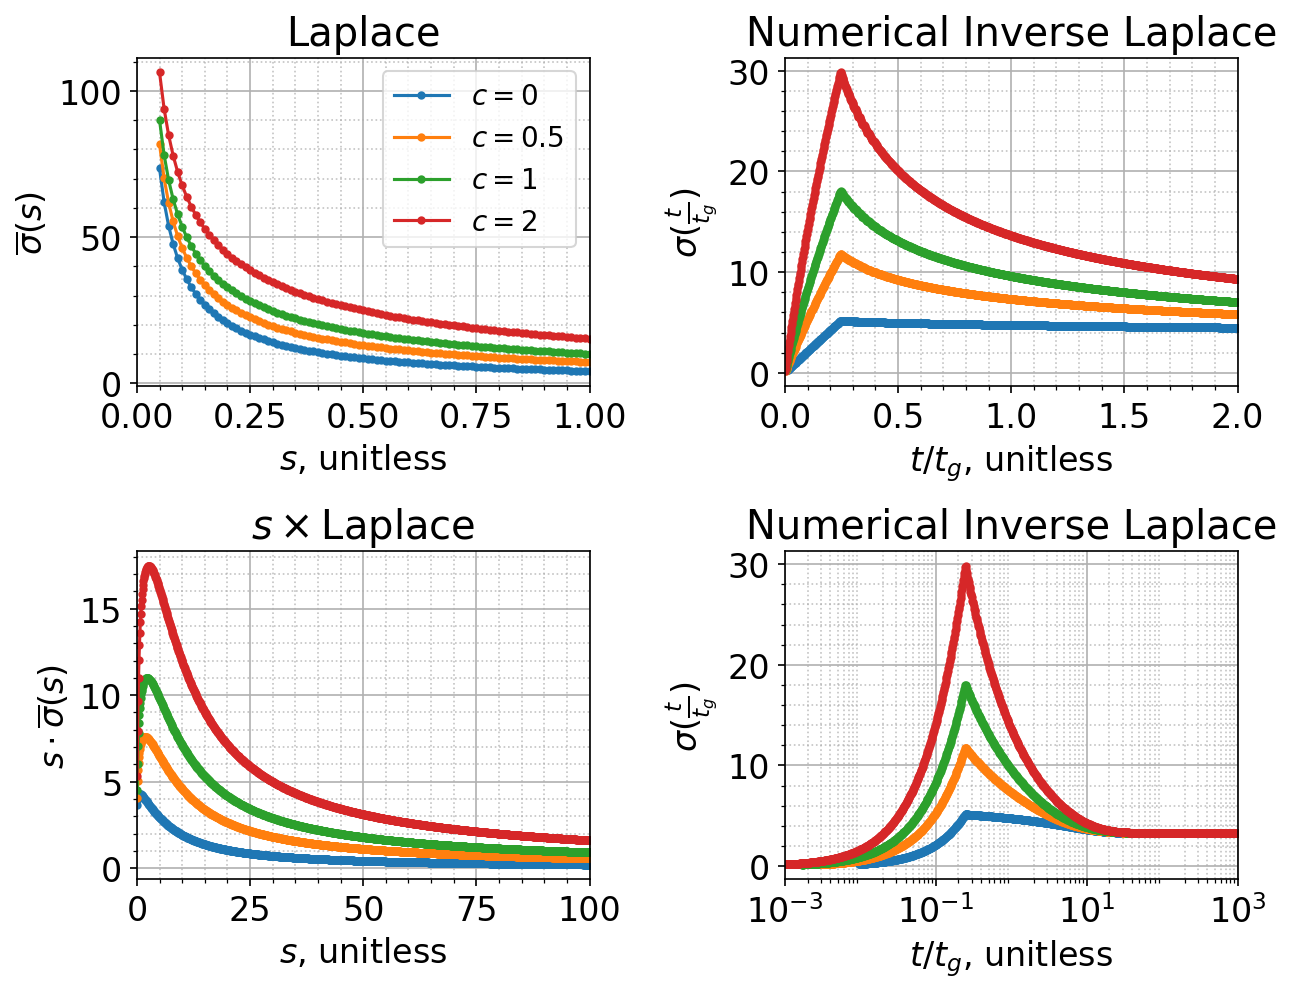

In [ ]:
#@title # ViscoporoelasticModel3
importlib.reload(plotting)
plotting.reload_imports()
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel3

ViscoporoelasticModel3.Ezz = 19  # kPa
ViscoporoelasticModel3.Vrz = 0.24  #unitless
ViscoporoelasticModel3.strain_rate = 0.01  # sec^-1

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel3(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$c={c}$") 
                              for c in [0, 0.5, 1, 2]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
plot_times_log = np.logspace(-3, 3, num=1001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    #display(vpe.get_var_df())


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

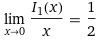

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
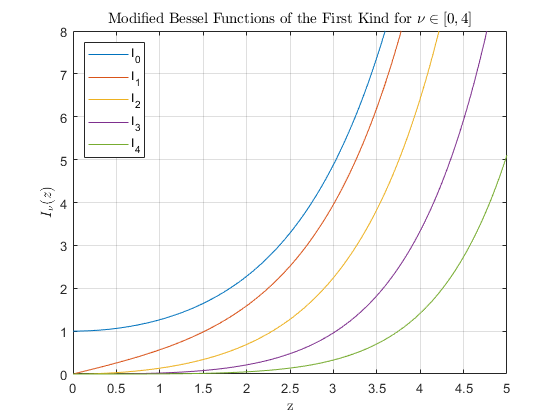

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

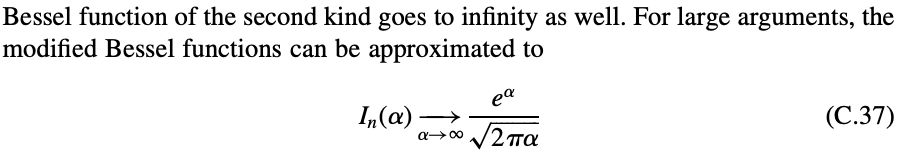


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

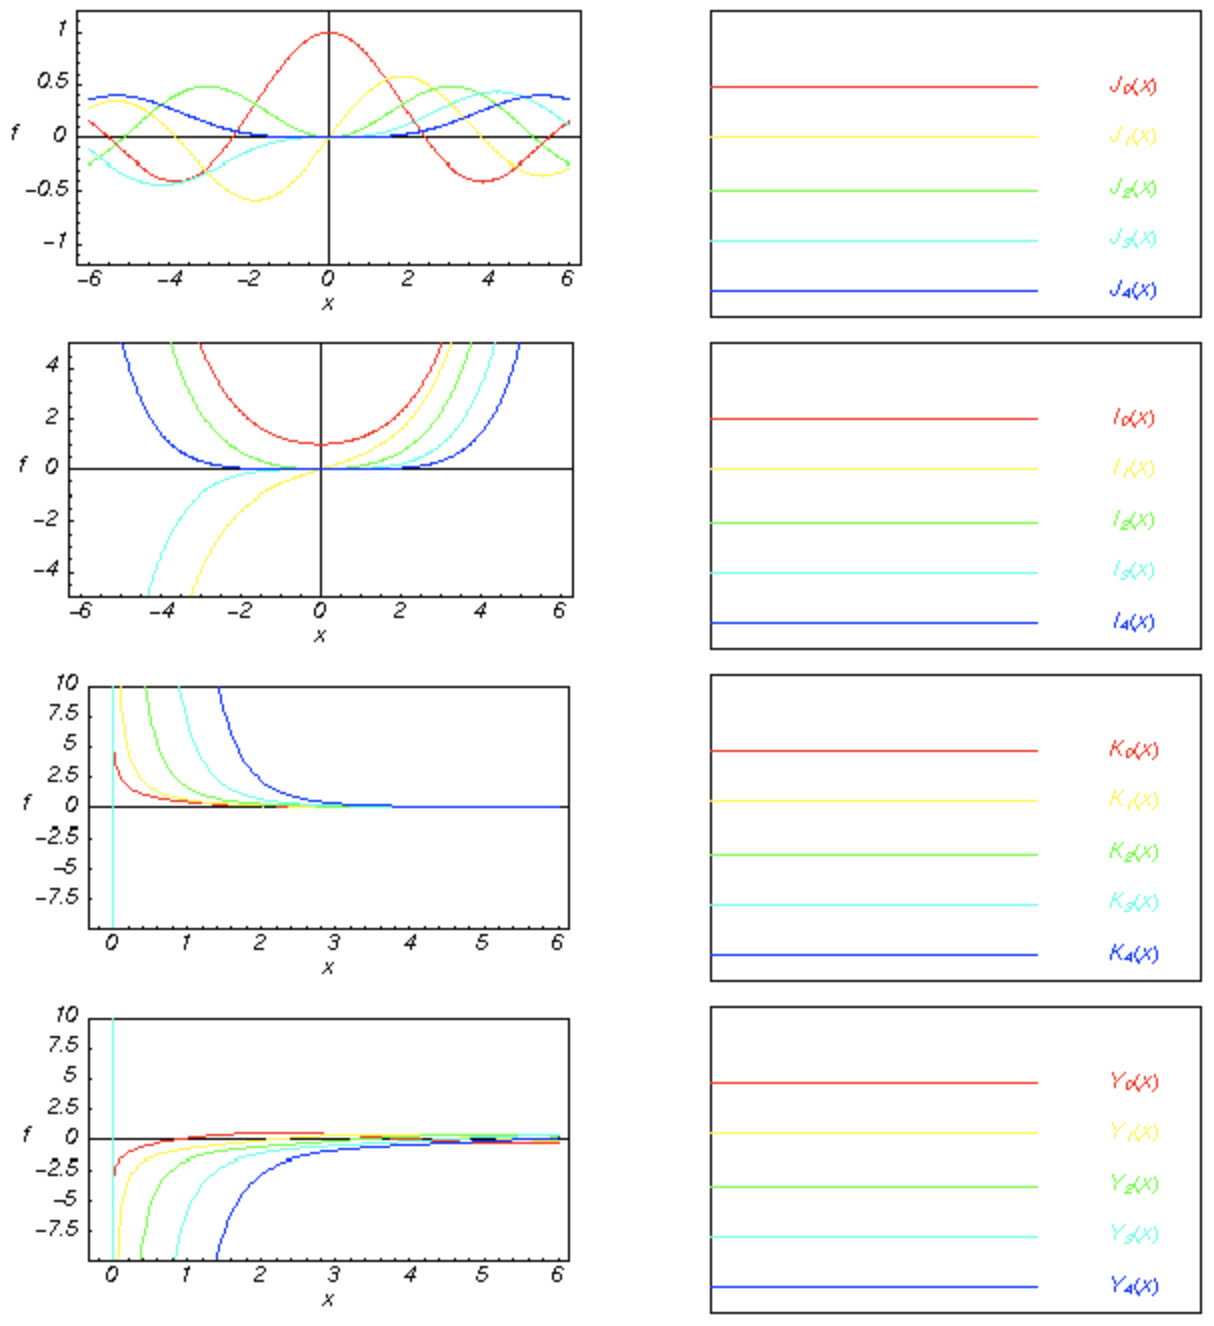

Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf
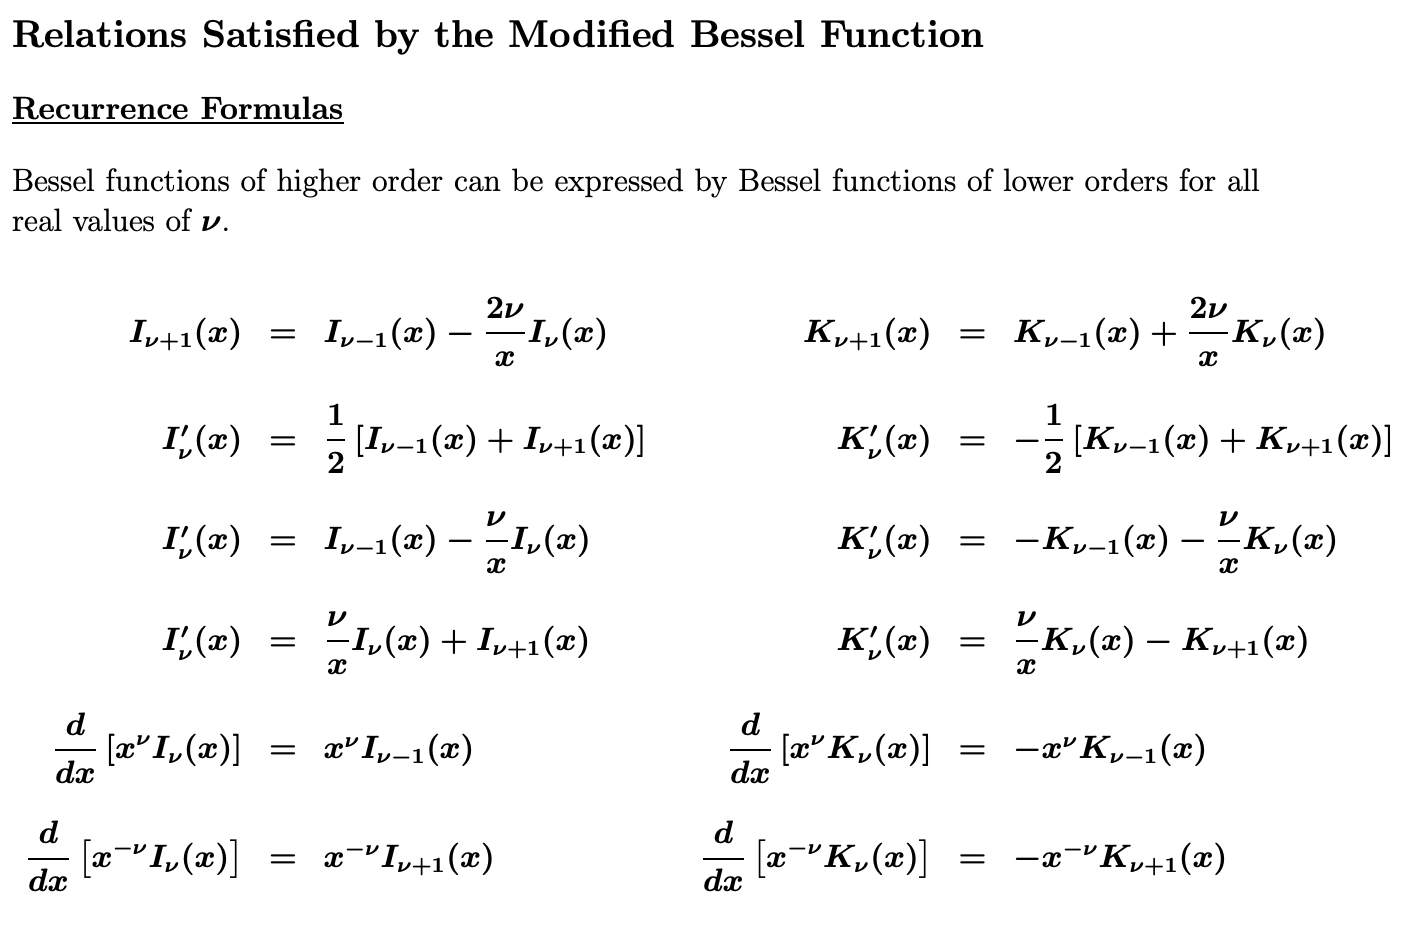

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

x^2 y'' + x y' + (x^2 - v^2)y=0

$x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=0$
```
$x^2 d^2 ydx^2 +x dy dx +(x^2 −ν^2 )y=0$
```
is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions
of the first and second kind as follows:

$y=AJν(x)+BYν(x)$
```
y=AJν(x)+BYν(x)
```
whereAandBare arbitrary constants. While Bessel functions are often presented in text
books and tables in the form of integer order, i.e. ν=0, 1 , 2 ,...,infact they are defined
for all real values of−∞<ν<∞.

### 2. Bessel Functions

```
a) First Kind: Jν(x)in the solution to Bessel’s equation is referred to as a Bessel
function of the first kind.
b) Second Kind: Yν(x) in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.
b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as
```
```
Hν(1)(x)=Jν(x)+iYν(x) x> 0
Hν(2)(x)=Jν(x)−iYν(x) x> 0
```
```
Because of the linear independence of the Bessel function of the first and second
kind, the Hankel functions provide an alternative pair of solutions to the Bessel
differential equation.
```

### 3. Modified Bessel Equation

By lettingx= ix(wherei=

#### √

− 1 )inthe Bessel equation we can obtain the modified
Bessel equation of orderν,given as

```
x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=
```
The solution to the modified Bessel equation yields modified Bessel functions of the first and
second kind as follows:

```
y=CIν(x)+DKν(x) x> 0
```
### 4. Modified Bessel Functions

```
a) First Kind: Iν(x)in the solution to the modified Bessel’s equation is referred
to as a modified Bessel function of the first kind.
b) Second Kind: Kν(x)in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.
```

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

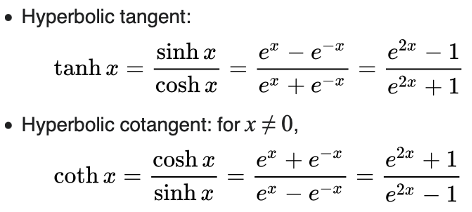